In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    


## overhead
import sys
import os
import gc
from tqdm import tqdm

## data structures
import pandas as pd
import numpy as np

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

## embedding
import umap

## model selection and tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

## models
from xgboost import XGBRegressor, XGBRFClassifier
from sklearn.linear_model import Lasso
from statsmodels.regression.linear_model import OLS

### load imputed data

In [2]:
celldyn = pd.read_feather("T:/laupodteam/AIOS/Bram/data/CellDyn/celldyn_FULL_transformed_df.feather")
celldyn.columns = celldyn.columns.str.lower()
gc.collect()

celldyn = celldyn[celldyn.age >= 0]

### select independent variables and age

In [3]:
meas_cols = [c for c in celldyn if ('combo' in c) or ('c_b_' in c)]

In [4]:
X = celldyn[meas_cols].to_numpy()
y = celldyn.age.to_numpy()

In [31]:
from sklearn.base import BaseEstimator
class RegrSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = Lasso(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    # def predict_proba(self, X):
    #     return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [42]:
parameters = [
    {
        'regr__estimator': [Lasso()],
        
    },
    {
        'regr__estimator': [XGBRegressor()],
    },
]


In [75]:
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("regr",XGBRegressor())
])


### subsampling to make it less cruesome

In [5]:
idx = np.random.randint(0,X.shape[0],size = 20000)
X_sample = X[idx,:]
y_sample = y[idx]

In [84]:
parameters = [{'regr__max_depth':[1,2,5,10],"regr__gamma":[0.01,0.1,0.2,0.4,0.6],"regr__n_estimators":[50,100,200,500],'regr__n_jobs':[3]}]
# parameters = [{'regr__alpha':[1,10,100]}]

folds = GroupKFold(n_splits=10)

for train,test in tqdm(folds.split(X_sample,y_sample,groups=celldyn.studyid_alle_celldyn[idx])):
    gscv = RandomizedSearchCV(pipe, parameters, cv=10, n_jobs=3, return_train_score=False, verbose=3)
    gscv.fit(X_sample[train,:],y_sample[train])
    print(gscv.score(X_sample[test,:],y_sample[test]))
    print(gscv.best_estimator_.named_steps.regr.max_depth)

0it [00:00, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


1it [26:09, 1569.90s/it]

0.4459444834686661
2
Fitting 10 folds for each of 10 candidates, totalling 100 fits


2it [49:35, 1473.06s/it]

0.44163299841727477
5
Fitting 10 folds for each of 10 candidates, totalling 100 fits


2it [1:11:33, 2146.96s/it]


KeyboardInterrupt: 

In [83]:
gscv.best_estimator_.named_steps.regr.max_depth

2

In [78]:
y_pred = gscv.predict(X_sample[test,:])

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

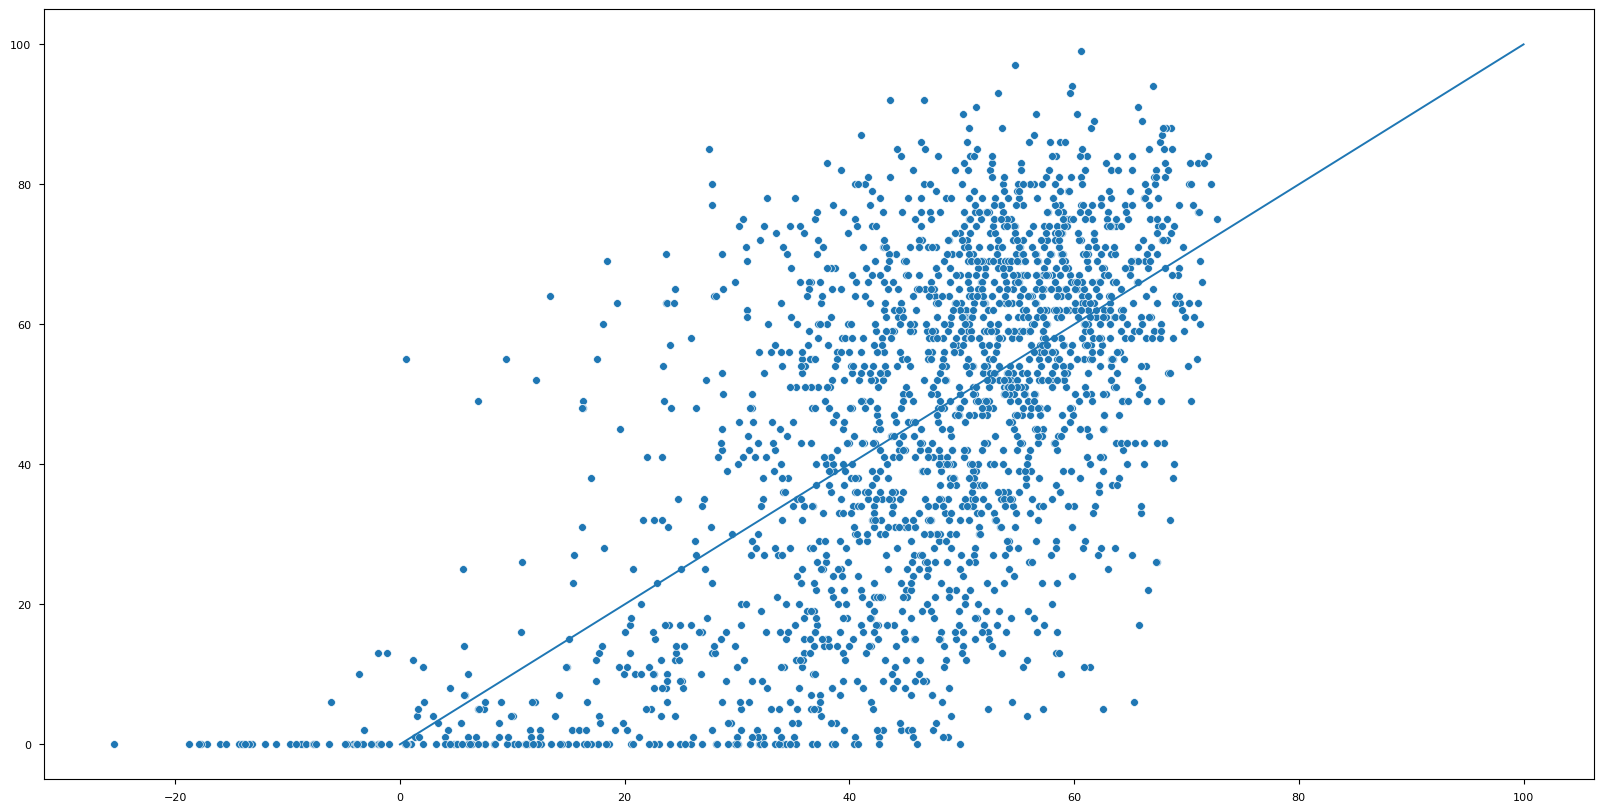

In [79]:
plt.style.use("seaborn-paper")

plt.figure(figsize = (20,10))

sns.scatterplot(y_pred,y_sample[test])
sns.lineplot([0,100],[0,100])

In [80]:
residuals = y_pred-y_sample[test]

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

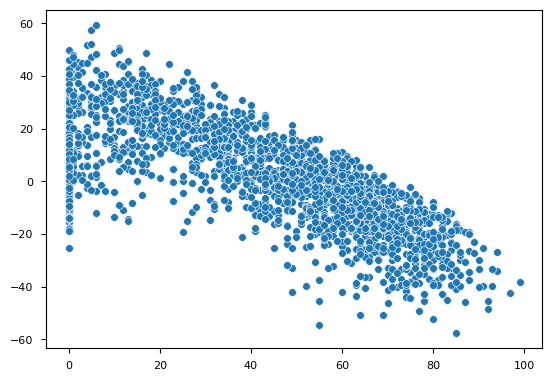

In [81]:
sns.scatterplot(y_sample[test],residuals)

### temp

In [6]:
from sklearn.decomposition import PCA

import umap

In [7]:
pca = PCA(n_components=30)

um = umap.UMAP(n_components=5)

In [8]:
X_emb = pca.fit_transform(X_sample)

In [9]:
from hembedder.utils.quality_metrics import CDEmbeddingPerformance as cep

In [10]:
X_sample = X_sample.astype(np.float32)
X_emb = X_emb.astype(np.float32)

In [11]:
import cProfile 
perf = cep()
cProfile.run("perf.score(X_sample,X_emb[:,:6],subsampling=1000)","results_profile")

Metric                    Mean    Standard deviation
--------------------  --------  --------------------
Trustworthiness       0.926529            0.00316256
Knn overlap           0.9                 0
Distance correlation  0.916707            0.00603414
Random triplets       0.86862             0.0038817


Supsampling of 1000 samples for 10 rounds each
Time taken 0.72 minutes


In [12]:
import pstats
from pstats import SortKey
p = pstats.Stats('results_profile')


p.strip_dirs().sort_stats('cumtime').print_stats()

Wed Jan 18 09:24:14 2023    results_profile

         2523507 function calls (2323081 primitive calls) in 43.364 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   43.364   43.364 {built-in method builtins.exec}
        1    0.000    0.000   43.364   43.364 <string>:1(<module>)
        1    0.000    0.000   43.364   43.364 quality_metrics.py:105(score)
        1    0.003    0.003   43.364   43.364 quality_metrics.py:175(score_subsampling)
       10    0.008    0.001   43.358    4.336 quality_metrics.py:116(metrics_scores_iter)
       10    0.000    0.000   39.615    3.961 quality_metrics.py:56(_return_distance_correlation)
       10    0.000    0.000   38.994    3.899 _dcor.py:998(distance_correlation)
       10    0.000    0.000   38.994    3.899 _dcor.py:876(distance_correlation_sqr)
       10    0.000    0.000   38.994    3.899 _dcor.py:190(<lambda>)
       10    0.000    0.000   38.994    3.

In [11]:
import multiprocessing
from sklearn.manifold import trustworthiness
import copy

In [14]:
def return_trustworthiness(args):
    X,X_embedded = args
    return(trustworthiness(X,X_embedded))

p = multiprocessing.Pool(processes=5)
results = [
    p.apply_async(return_trustworthiness,
    (copy.deepcopy(X_sample),copy.deepcopy(X_emb[:,:6]))) for _ in range(5)
    ]

results[0].get(timeout=600)

TimeoutError: 

In [15]:
p.close()

In [16]:
trustworthiness(X_sample,X_emb[:,:6])

0.9373821948779512

In [27]:
from joblib import Parallel, delayed

def return_trustworthiness(args):
    X,X_embedded = args
    return trustworthiness(X,X_embedded)


out = Parallel(n_jobs=5,verbose=100,pre_dispatch='1.5*n_jobs')(
    delayed(return_trustworthiness)((X_sample,X_emb[:,:6])) 
    for _ in range(5))
print(out)

def return_dcor(args):
    X,X_embedded = args
    return dcor.distance_correlation(X_sample,X_emb[:,:6])

out_dcor = Parallel(n_jobs=5,verbose=100,pre_dispatch='1.5*n_jobs')(
    delayed(return_dcor)((X_sample,X_emb[:,:6])) 
    for _ in range(5))
print(out_dcor)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   53.4s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   53.7s remaining:  1.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   53.7s remaining:   35.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   53.8s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   53.8s finished
[0.9373821948779512, 0.9373821948779512, 0.9373821948779512, 0.9373821948779512, 0.9373821948779512]
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.6min finished
[0.9681

In [25]:
import dcor

dcor.distance_correlation(X_sample,X_emb[:,:6])

0.9681557184392078

In [73]:
from scipy.spatial.distance import jaccard
import faiss

In [86]:
def create_knn_search(X,k):
    """
    HELPER function for knn_overlap
    """
    index = faiss.IndexFlatL2(X.shape[1])
    index.add(X.astype(np.float32))
    D,I = index.search(X.astype(np.float32), k)
    return D,I
D,I = create_knn_search(X_sample,50)

D_emb,I_emb = create_knn_search(X_emb,50)
ds_arry = np.zeros(I.shape[0]) 
dist = jaccard
for i in range(I.shape[0]):
    ds_arry[i] = dist(I[i,:],I_emb[i,:])
np.median(ds_arry) 

0.98

In [46]:
for i in range(3,31):
    print("___________________\n",i,"\n",perf.score(X_sample,X_emb[:,:i]),"\n___________________")

Metric                    Mean    Standard deviation
--------------------  --------  --------------------
Trustworthiness       0.836369            0.00573976
Knn overlap           0.9                 0
Distance correlation  0.847461            0.00939095
Random triplets       0.81416             0.00911868


Supsampling of 1000 samples for 10 rounds each
Time taken 0.61 minutes
___________________
 3 
 None 
___________________
Metric                    Mean    Standard deviation
--------------------  --------  --------------------
Trustworthiness       0.87982             0.00495863
Knn overlap           0.9                 0
Distance correlation  0.877351            0.0086946
Random triplets       0.83986             0.00530362


Supsampling of 1000 samples for 10 rounds each
Time taken 0.59 minutes
___________________
 4 
 None 
___________________
Metric                    Mean    Standard deviation
--------------------  --------  --------------------
Trustworthiness       0.90799

KeyboardInterrupt: 